In [1]:
# default_exp ensembles
# default_cls_lvl 2

# Chapter 7. Ensemble Learning & Random Forests
>

- Suppose you pose a random question to thousands of people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an **expert's answer** (*really*).
    - This is called the *wisdom of the crowd*.
- Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than the best individual predictor.
- A group of predictors is called an ensemble. Thus this technique is called **ensemble learning**, and an ensemble learning algorithm is called an **Ensemble Method**.
- As an example of an ensemble method, you can train a group of decision tree classifiers, each on a *random subset* of the training data. 
    - Such an ensemble of decision trees is called a **random forest**. 
    - Despite its simplicity, this is one of the most powerful machine learning algorithms available today.
- You will often use ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor.
- In this chapter, we will discuss the most famous ensemble learning methods, including:
    - **Bagging, Boosting, & Stacking**.

## Voting Classifiers

- Suppose you have trained a few classifiers, each achieving an 80% accuracy.
- A very simple way to create an even better classifiers is to aggregate the predictions of all your classifiers and choose the prediction that is the most frequent.
- This majority voting classifier is called a **Hard Voting** Classifier:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/Hard_voting.png"></div>

- Somewhat surprisingly, this classifier achieves an even better accuracy than the best predictor in the ensemble.
    - Even if each classifier is a weak learner (does slightly better then random guessing).
        - Provided there are a sufficient number of weak learners and enough diversity.
- Due to the law of large numbers, if you build an ensemble containing 1,000 classifiers with individual accuracies of $51%$ & trained for binary classification, If you predict the majority voting class, you can hope for up to $75%$ accuracy.
    - This is only true if all classifiers are completely independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data.
- One way to get diverse classifiers is use different algorithms for each one of them & train them on different subset of the training data. 
- Let's implement a hard voting ensemble learner using scikit-learn:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
log_clf = LogisticRegression(solver='lbfgs')
rf_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='scale')

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [5]:
X, y = datasets.make_moons(n_samples=10000, noise=0.5)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [6]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6700, 2), (6700,), (3300, 2), (3300,))

In [7]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)], voting='hard')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

- Let's take a look at the performance of each classifier + ensemble method on the validation set:

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
for clf in [log_clf, rf_clf, svm_clf, voting_clf]:
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_hat))

LogisticRegression 0.8181818181818182
RandomForestClassifier 0.8024242424242424
SVC 0.8324242424242424
VotingClassifier 0.8287878787878787


- There you have it! The voting classifier slightly outperforms the individual classifiers.

- If all ensemble method learners can estimate class probabilities, you can average their probabilities per class then predict the class with the highest probability.
    - This is called **Soft voting**.
    - It often yields results better than hard voting because it weights confidence.

## Bagging & Pasting

- Another approach to having different algorithms trained on the same dataset is to have one algorithm but trained on random subsets of the training data.
    - When subset sampling is performed with replacement, this is called **bagging**.
    - When sampling is performed without replacement, this is called **Pasting**.
- Bagging is showcased in the following figure:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/bagging.png"></div>

- Once the ensemble method is done training, we can infer using *mode* for classification or *avg* for regression.
- Each individual predictor has a higher bias than if it were trained on the whole training dataset, but aggregation reduces both bias and variance.
- Because ensemble learners use separate different algorithms, they can be easily parallalizable, and that is why bagging and pasting are so popular, they scale very well.

### Bagging & Pasting in Scikit-Learn

- Let's implement bagging in scikit-learn:

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

In [13]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [14]:
y_hat = bag_clf.predict(X_val)

- Bagging models often result in a slightly more biased model than the base predictor, but because of the diversity of the training subsets, it has much smoother decision curves meaning it has usually a lower variance
- The comparable/slightly higher bias comes from the fact that we are sampling with replacement, leading to points making it to multiple child learners.
- following is a comparison

<div style="text-align:center;"><img style="width:66%;" src="static/imgs/dt_bagging.png"></div>

- Overall, bagging generally produce better models, and this explains why it's very popular.
    - but if you have compute time and power you can use cross validation to test both bagging and pasting for your case and decide which works better.

### Out-of-Bag Evaluation

- With bagging, some instances will be sampled several times for several predictors, while others won't be sampled at all.
- Only about 63% of the instances are sampled for each predictor.
- The other 37% of instances not sampled are called Out-of-Bag (oob) instances. 
    - Note that they're not the same 37% for all predictors.
- Since the individual predictor never sees the oob samples, it can be evaluated on the oob data without the need for a separate validation set.
- You can evaluate the ensemble itself by averaging the oob scores of each predictor.
- Let's do this using scikit-learn:

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=0.63, bootstrap=True, n_jobs=-1, oob_score=True)

In [16]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.63, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [17]:
bag_clf.oob_score_

0.8004477611940298

Let's verify this estimation using the validation set:

In [18]:
y_hat = bag_clf.predict(X_val)

In [19]:
accuracy_score(y_val, y_hat)

0.8093939393939394

- Close enough!
- The oob decision function is also available using scikit-learn's API, since our classifier is a decision tree then the decision function is a ratio that can be expressed as a probability, let's take a look at it for each instance:

In [20]:
bag_clf.oob_decision_function_

array([[0.44839858, 0.55160142],
       [0.01858736, 0.98141264],
       [0.93448276, 0.06551724],
       ...,
       [0.0647482 , 0.9352518 ],
       [0.62730627, 0.37269373],
       [0.        , 1.        ]])

## Random Patches & Random Subspaces

- We can sample features as well.
- Sampling is controlled by two hyper-parameters: `max_features` & `bootstrap_features`.
- Thus, each predictor will be trained on a random feature sample.
- This technique is especially useful when you're dealing with high-dimensional input as as imagery. 
- Sample both instances and features is called the random patches method.
- Sampling only features is called the random subspaces method.
- Sampling features results in a more predictor diversity.

## Random Forests

- A random forest is an ensemble of decision trees.
- Let's use its scikit-learn implementation:

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

In [23]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
y_pred_rf = rnd_clf.predict(X_val)

- The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

In [25]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### Extra-Trees

- When you are growing a tree in a random forest, only a subset of features are considered when splitting.
- It's possible to make the trees more random by choosing different threshold of the features rather than searching for the best possible threshold.
    - Such a model is called **Extremely Randomized Trees Ensemble**.
- When don't really know if an extremely randomized trees model will or will not outperform a classical random forest model.
    - Generally, the only way to know is to try both and check their results using cross validation.

### Feature Importance

- Yet another great quality of random forests is that they make it so easy to measure the importance of each feature.
- We measure the importance by averaging the reduced impurity of each node that uses a certain feature across all trees in the forest.
    - More exactly it's a weighted average beacuse each node has a number of samples that is used to weight.
- Let's get feature importance using random forests on the iris dataset:

In [26]:
from sklearn.datasets import load_iris

In [27]:
iris = load_iris()

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [29]:
rnd_clf.fit(iris['data'], iris['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09511858189679075
sepal width (cm) 0.021817079798945354
petal length (cm) 0.46014470905510807
petal width (cm) 0.42291962924915605


- Let's plot pixel-wise MNIST feature importance:

In [31]:
from sklearn.datasets import load_digits

In [32]:
digits = load_digits()

In [33]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [34]:
rnd_clf.fit(digits['data'], digits['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

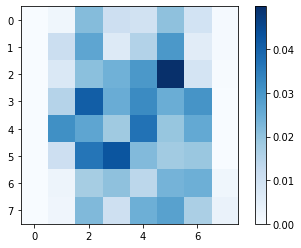

In [35]:
plt.imshow(rnd_clf.feature_importances_.reshape(8,8), cmap='Blues')
plt.colorbar()
plt.show()

- Random Forest are very handy to get a quick understanding of what features actually matter, particularly if you need to perform feature selection.

## Boosting

- Boosting refers to any ensemble method that can combine several weak learners into a strong learner.
- The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 
- There are many boosting methods available, but by far the most popular one is **AdaBoost** (Adaptive boosting) and **gradient boosting**.
- Let's start with Adaboost:

### AdaBoost

- One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that were underfitted.
- this results in the later predictors focusing more and more on the hard cases.
- & This is the technique used by Adaboost.
- The following figure demenstrates the process

<div style="text-align:center;"><img style="width:50%;" src="static/imgs/adaboost.png"></div>

- The algorithm first trains a base classifier and use it to make predictions on the training set. the algorithm then increases the weight of the missclassified instances and pass its weights + the data to the next predictor.
- This iterative learning approach shares similarities with gradient descent, except in gradient descent we're using the gradients to minimize a cost function, but with AdaBoost we're simply adding more learners to the chain.
- There is one important drawback of this method, It cannot be parallalized because each predictor needs the output of the previous predictor.
- Let's take a closer look at the Adaboost Algorithm:
- Each instance weight $w^{(i)}$ is initially set to $1/m$.
- A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set using the general formula, where:
    - $\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance.
$$r_j=\frac{\sum_{i=1(\hat{y_j^{(i)}}\neq{y^{(i)}})}^{m} w^{(i)}}{\sum_{i=1}^{m}w^{(i)}}$$
- the predictor's weight $\alpha_{0}$ is computed as follows:
$$\alpha_{j}=\eta log(\frac{1-r_j}{r_j})$$
- The more accurate the predictor is, the higher its weight will be. If it's just guessing randomly, then its weight will be close to zero.
    - However, If it's most often wrong, then its weight will be negative.
- Next the adaboost algorithm updates the instance weights which boosts the weights of the misclassified instances:
$$\forall i \in \{1,2, \dots, m\} \\ w^{(i)} \leftarrow \begin{cases}
w^{(i)},  & \text{if $\hat{y}^{(i)}_j = y^{(i)}$} \\
w^{(i)}exp(\alpha_{j}), & \text{else}
\end{cases}$$
- Then all the instance weights are normalized (are divided by the sum of the weights).
- Finally, a new predictor is trained using the updated weights, and the whole process is repeated again.
- The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.
- To make predictions, Adaboost simply computes the predictions of all the predictors and weight them using the predictor weights $\alpha_j$.
- The predicted class is the one that receives the majority of the weighted votes (where $N$ is the number of predictors):
$$\hat{y}(x)=argmax_{k}\sum_{j=1 \; \hat{y}_j(x)=k}^{N}\alpha_j$$
- Let's use scikit-learn's implementation of Adaboost with 1 depth decision trees:

In [36]:
from sklearn.ensemble import AdaBoostClassifier

In [37]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                             n_estimators=200, algorithm='SAMME.R', 
                             learning_rate=0.5)

In [38]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
accuracy_score(ada_clf.predict(X_val), y_val)

0.8272727272727273

### Gradient Boosting

- Just like Adaboost, Gradient Boosting works by sequentially adding predictors to an ensemble each one correcting its predecessor.
- However, instead of tweaking the instance weights at every iteration like Adaboost does, this method tries to fit the new predictor to the **residual errors** made by the previous predictor.
- Let's go through a simple regression example, First let's fit a decision tree regressor to a synthetically generated training set:

In [41]:
X = np.linspace(start=0, stop=1, num=500)
y = (X-0.5)**2 + np.random.randn(500)/50.
X = X[..., None]  # 1 feature

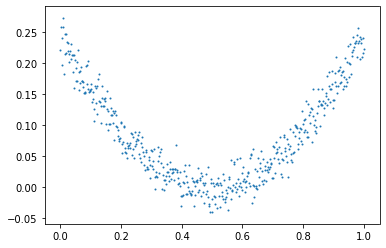

In [42]:
plt.scatter(X.squeeze(), y.squeeze(), s=1)
plt.show()

In [43]:
from sklearn.tree import DecisionTreeRegressor

In [44]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)

In [45]:
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

- Next, we'll train a second decision tree regressor on the errors made by the first tree:

In [46]:
y2 = y - tree_reg1.predict(X)

In [47]:
tree_reg2 = DecisionTreeRegressor(max_depth=2)

In [48]:
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

- Now we train a third regressor on the errors made by the second regressor:

In [49]:
y3 = y2 - tree_reg2.predict(X)

In [50]:
tree_reg3 = DecisionTreeRegressor(max_depth=2)

In [51]:
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

- Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [52]:
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

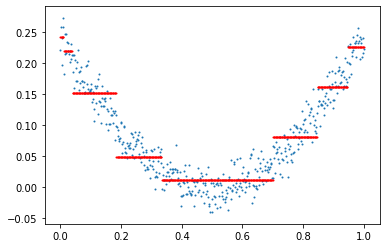

In [53]:
plt.scatter(X.squeeze(), y.squeeze(), s=1)
plt.scatter(X.squeeze(), y_pred.squeeze(), s=1, c='red')
plt.show()

- The following figure showcases the predictions made by sequential models, on the left we have gradient boosting, on the right we have Adaboost:

<div style="text-align:center;"><img style="width:66%;" src="static/imgs/boosting_ensembles.png"></div>

- A simpler way to train Gradient Boosting Regressor Trees ensemble is to use Scikit-Learn as follows:

In [54]:
from sklearn.ensemble import GradientBoostingRegressor

In [55]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)

In [56]:
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

- The learning rate in the hyper-parameters scales the contribution of each tree.
    - If you set it to a low value, you will need more trees in the ensemble to fit the model to the training set.
        - But the predictions will usually generalize better.
- For a fixed learning rate, you will have to figure out the optimal number of trees to not underfit/overfit.
    - Early stopping can be used.

<div style="text-align:center;"><img style="width:66%;" src="static/imgs/ensemble_overunderfit.png"></div>

- The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees: 

In [57]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [59]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [60]:
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=120, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

In [63]:
bst_n_estimators = np.argmin(errors) + 1
bst_n_estimators

67

In [64]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)

In [65]:
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=67, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

- Our `argmin` based pick and the resulting model are showcased in the following figure:

<div style="text-align:center;"><img style="width: 66%;" src="static/imgs/gradient_boosting_optimization.png"></div>

- It is also possible to implement early stopping by actually stopping early and not export results for a large number of trees then use `argmin`. 
- This code stops training when the validation error does not improve for five iterations in a row:

In [66]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0

In [68]:
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # Early Stopping

- It's worth noting that an optimized implementation of gradient boosting is available in the popular python library **`XGBoost`** (Stands for Extreme Gradient Boosting).
- Let's try it out:

In [70]:
import xgboost

In [71]:
xgb_reg = xgboost.XGBRegressor()

In [72]:
xgb_reg.fit(X_train, y_train)

[10:27:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

- The library can take care of early stopping for you:

In [74]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

[10:28:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.373822
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.337234
[2]	validation_0-rmse:0.304619
[3]	validation_0-rmse:0.275285
[4]	validation_0-rmse:0.248496
[5]	validation_0-rmse:0.224535
[6]	validation_0-rmse:0.202935
[7]	validation_0-rmse:0.183518
[8]	validation_0-rmse:0.165973
[9]	validation_0-rmse:0.150271
[10]	validation_0-rmse:0.136123
[11]	validation_0-rmse:0.123259
[12]	validation_0-rmse:0.11172
[13]	validation_0-rmse:0.101357
[14]	validation_0-rmse:0.092034
[15]	validation_0-rmse:0.083758
[16]	validation_0-rmse:0.076379
[17]	validation_0-rmse:0.069841
[18]	validation_0-rmse:0.063972
[19]	validation_0-rmse:0.058725
[20]	validation_0-rmse:0.054021
[21]	validation_0-rmse:0.049851
[22]	validation_0-rmse:0.046189
[23]	validation_0-rmse:0.042995
[24]	validation_0-rmse:0.040171
[25]	validation_0-rmse:0.03767


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [75]:
y_pred = xgb_reg.predict(X_val)

In [76]:
mean_squared_error(y_val, y_pred)

0.00046120108202572606

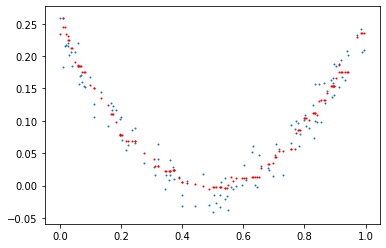

In [79]:
plt.scatter(X_val.squeeze(), y_val.squeeze(), s=1)
plt.scatter(X_val.squeeze(), y_pred.squeeze(), s=1, c='red')
plt.show()

## Stacking

- The last ensemble method we will discuss in this chapter is called stacking (short for stacked generalization).
- It is based on a simple idea
    - Instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, Why don't we train a model to do that for us?
    - The final aggregator learner is typically called a **blender** or a **meta-learner**.
- Following figure outlines the idea of learning aggregations:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/blender.png"></div>

- To train a blender, a common approach is to use a holdout set.
- We first train predictors on the first holdout set.
- Then the first layer predictors are used to export predictions of the second held-out set.
    - This ensures that the predictions are clean since the predictors never saw the 2nd held-out instances during training.
- The result is that for each instance in the holdout set, we have 3 predictions, the 3 predictions per row will be considered as input for the blender.
    - The blender is trained on this new dataset.
- Unfortunately, `scikit-learn` doesn't support stacking directly.

# Exercices

**1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, How? If not, Why?**

- Yes, we can combine their predictions using:
    - Classification
        - hard voting (y_hat=mode(preds))
        - soft voting for classification (averaging estimated class probabilities and taking the class associated with the highest one).
    - Regression
        - Taking the mean of the predicted values from each model.

**2. What is the difference between hard & soft voting classifiers?**
- Hard voting: we take all of the predictions and output the mode (the most frequently predicted class).
- Soft voting: we average all probabilities associated with each class and output the class with the highest averaged probability.

**3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles? Boosting ensembles, random forests, stacking ensembles?**

- Bagging Ensemble (Bootstrap Aggregation — Sampling with replacement + feature subsetting): It is parallelizable.
- Pasting Ensemble (Only difference — Sampling without replacement): It is parallelizable.
- Boosting Ensemble (Trains predictors sequentially): Not parallelizable.
- Random Forests: Parallelizable.
- Stacking Ensemble: Stacking is partly parallelizable, we can train massive predictors in the first layer but we have to wait for the ith training phase to finish before training subsequent layers (and the final blender).

**4. What is the benefit of out-of-bag evaluation?**

- We don't need a hold-out set and we evaluate each individual predictor on the fly and export and estimate of the overall performance of the ensemble model.